In [1]:
# These must be in scope (from your provided code).
# If you already imported them elsewhere, you can skip redefining.
from torchvision import transforms
import torch
import numpy as np
from PIL import Image
import regex as re
import random, os, math
from torch.utils.data import Dataset

In [2]:
class CustomDiffusionDataset(Dataset):
    """
    A dataset to prepare the instance and class images with the prompts for fine-tuning the model.
    It pre-processes the images and the tokenizes prompts.
    """

    def __init__(
        self,
        concepts_list,
        concept_type,
        with_style_replacement,
        tokenizer,
        size=512,
        center_crop=False,
        with_prior_preservation=False,
        num_class_images=200,
        hflip=False,
        aug=True,
    ):
        self.size = size
        self.center_crop = center_crop
        self.tokenizer = tokenizer
        self.interpolation = Image.LANCZOS
        self.aug = aug
        self.concept_type = concept_type
        self.with_style_replacement = with_style_replacement

        self.instance_images_path = []
        self.class_images_path = []
        self.with_prior_preservation = with_prior_preservation
        for concept in concepts_list:
            with open(concept["instance_data_dir"], "r") as f:
                inst_images_path = f.read().splitlines()
            with open(concept["instance_prompt"], "r") as f:
                inst_prompt = f.read().splitlines()
            inst_img_path = [
                (x, y, concept["caption_target"])
                for (x, y) in zip(inst_images_path, inst_prompt)
            ]
            self.instance_images_path.extend(inst_img_path)

            if with_prior_preservation:
                class_data_root = Path(concept["class_data_dir"])
                if os.path.isdir(class_data_root):
                    class_images_path = list(class_data_root.iterdir())
                    class_prompt = [
                        concept["class_prompt"] for _ in range(len(class_images_path))
                    ]
                else:
                    with open(class_data_root, "r") as f:
                        class_images_path = f.read().splitlines()
                    with open(concept["class_prompt"], "r") as f:
                        class_prompt = f.read().splitlines()

                class_img_path = [
                    (x, y) for (x, y) in zip(class_images_path, class_prompt)
                ]
                self.class_images_path.extend(class_img_path[:num_class_images])

        random.shuffle(self.instance_images_path)
        self.num_instance_images = len(self.instance_images_path)
        self.num_class_images = len(self.class_images_path)
        self._length = max(self.num_class_images, self.num_instance_images)
        self.flip = transforms.RandomHorizontalFlip(0.5 * hflip)

        self.image_transforms = transforms.Compose(
            [
                self.flip,
                transforms.Resize(
                    size, interpolation=transforms.InterpolationMode.LANCZOS
                ),
                transforms.CenterCrop(size)
                if center_crop
                else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def preprocess(self, image, scale, resample):
        outer, inner = self.size, scale
        if scale > self.size:
            outer, inner = scale, self.size
        top, left = np.random.randint(0, outer - inner + 1), np.random.randint(
            0, outer - inner + 1
        )
        image = image.resize((scale, scale), resample=resample)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)
        instance_image = np.zeros((self.size, self.size, 3), dtype=np.float32)
        mask = np.zeros((self.size // 8, self.size // 8))
        if scale > self.size:
            instance_image = image[top : top + inner, left : left + inner, :]
            mask = np.ones((self.size // 8, self.size // 8))
        else:
            instance_image[top : top + inner, left : left + inner, :] = image
            mask[
                top // 8 + 1 : (top + scale) // 8 - 1,
                left // 8 + 1 : (left + scale) // 8 - 1,
            ] = 1.0
        return instance_image, mask

    def __getprompt__(self, instance_prompt, instance_target):
        anchor=""
        if self.concept_type == "style":
            # Clean up instance_target
            instance_target = instance_target.replace("_", " ")
            instance_target = instance_target.replace(" Style", "")

            # Replace style in prompt or append it
            if self.with_style_replacement:
                # Replace the style in the prompt with the target style
                instance_prompt = re.sub(
                    r"in\s+.*?style", f"in {instance_target} style", instance_prompt, flags=re.IGNORECASE
                )
                if instance_prompt == instance_target:
                    instance_prompt = f"An image in {instance_target} Style"
                    print(f"Unsuccessful replacement for style '{instance_target}' in prompt '{instance_prompt}'. Using '{instance_prompt}' instead.")
            else:
                r = np.random.choice([0, 1])
                instance_prompt = instance_prompt.replace(".", "")
                instance_prompt = (
                    f"{instance_prompt}, in {instance_target} Style"
                    if r == 0
                    else f"In {instance_target} Style, {instance_prompt}"
                )
        elif self.concept_type in ["nudity", "inappropriate_content"]:
            r = np.random.choice([0, 1, 2])
            instance_prompt = (
                f"{instance_target}, {instance_prompt}"
                if r == 0
                else f"in {instance_target} style, {instance_prompt}"
                if r == 1
                else f"{instance_prompt}, {instance_target}"
            )
        elif self.concept_type == "object":
            anchor, target = instance_target.split("+")
            if anchor == "*":
                instance_prompt = target
            else:
                # Replace anchor with target in prompt
                replaced_instance_prompt = re.sub(re.escape(anchor), target, instance_prompt, flags=re.IGNORECASE)
                if replaced_instance_prompt == instance_prompt:
                    replaced_instance_prompt = f"A {target} image"
                    print(f"Unsuccessful replacement for anchor '{anchor}' in prompt '{instance_prompt}'. Using '{replaced_instance_prompt}' instead.")
                instance_prompt = replaced_instance_prompt
        elif self.concept_type == "memorization":
            instance_prompt = instance_target.split("+")[1]
        return instance_prompt, anchor

    def __getitem__(self, index):
        example = {}
        instance_image, instance_prompt, instance_target = self.instance_images_path[
            index % self.num_instance_images
        ]
        example["image_path"] = instance_image
        instance_image = Image.open(instance_image)
        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")
        instance_image = self.flip(instance_image)
        # modify instance prompt according to the concept_type to include target concept
        # multiple style/object fine-tuning
        if ";" in instance_target:
            instance_target = instance_target.split(";")
            instance_target = instance_target[index % len(instance_target)]

        instance_anchor_prompt = instance_prompt
        instance_prompt, anchor = self.__getprompt__(instance_prompt, instance_target)
        example["anchor_prompt"] = instance_anchor_prompt
        example["target_prompt"] = instance_prompt
        example["anchor"] = anchor

        # apply resize augmentation and create a valid image region mask
        random_scale = self.size
        if self.aug:
            random_scale = (
                np.random.randint(self.size // 3, self.size + 1)
                if np.random.uniform() < 0.66
                else np.random.randint(int(1.2 * self.size), int(1.4 * self.size))
            )
        instance_image, mask = self.preprocess(
            instance_image, random_scale, self.interpolation
        )

        if random_scale < 0.6 * self.size:
            instance_prompt = (
                np.random.choice(["a far away ", "very small "]) + instance_prompt
            )
        elif random_scale > self.size:
            instance_prompt = (
                np.random.choice(["zoomed in ", "close up "]) + instance_prompt
            )

        example["instance_images"] = torch.from_numpy(instance_image).permute(2, 0, 1)
        example["mask"] = torch.from_numpy(mask)

        example["instance_prompt_ids"] = self.tokenizer(
            instance_prompt,
            truncation=True,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids
        example["instance_anchor_prompt_ids"] = self.tokenizer(
            instance_anchor_prompt,
            truncation=True,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids

        if self.with_prior_preservation:
            class_image, class_prompt = self.class_images_path[
                index % self.num_class_images
            ]
            class_image = Image.open(class_image)
            if not class_image.mode == "RGB":
                class_image = class_image.convert("RGB")
            example["class_images"] = self.image_transforms(class_image)
            example["class_mask"] = torch.ones_like(example["mask"])
            example["class_prompt_ids"] = self.tokenizer(
                class_prompt,
                truncation=True,
                padding="max_length",
                max_length=self.tokenizer.model_max_length,
                return_tensors="pt",
            ).input_ids

        return example


In [3]:
def collate_fn(examples, with_prior_preservation):
    input_ids = [example["instance_prompt_ids"] for example in examples]
    input_anchor_ids = [example["instance_anchor_prompt_ids"] for example in examples]
    pixel_values = [example["instance_images"] for example in examples]
    mask = [example["mask"] for example in examples]
    image_paths = [example["image_path"] for example in examples]
    target_prompts = [example["target_prompt"] for example in examples]
    anchor_prompts = [example["anchor_prompt"] for example in examples]
    anchors = [example["anchor"] for example in examples]
    # Concat class and instance examples for prior preservation.
    # We do this to avoid doing two forward passes.
    if with_prior_preservation:
        input_ids += [example["class_prompt_ids"] for example in examples]
        pixel_values += [example["class_images"] for example in examples]
        mask += [example["class_mask"] for example in examples]

    input_ids = torch.cat(input_ids, dim=0)
    input_anchor_ids = torch.cat(input_anchor_ids, dim=0)
    pixel_values = torch.stack(pixel_values)
    mask = torch.stack(mask)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    mask = mask.to(memory_format=torch.contiguous_format).float()

    batch = {
        "input_ids": input_ids,
        "input_anchor_ids": input_anchor_ids,
        "pixel_values": pixel_values,
        "mask": mask.unsqueeze(1),
        "image_paths": image_paths,
        "target_prompts": target_prompts,
        "anchor_prompts": anchor_prompts,
        "anchors": anchors
    }
    return batch



In [4]:
# --- Config you may edit ---
BASE_MODEL_DIR = "/users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/UnlearningMethods/base_models/UnlearnCanvas"  # HF repo id or local folder with SD
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float16 if DEVICE == "cuda" else torch.float32

# If you already have args.concepts_list prepared by your pipeline, you can reuse it.
# Otherwise, define a minimal concepts_list here that points to your generated files:
#   - images.txt : newline-separated absolute/relative paths to training images
#   - captions.txt: newline-separated prompts (same count/order as images.txt)
concepts_list = [
    {
        "class_data_dir": "/users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/UnlearningMethods/DoCo/anchor_datasets/style/doco_painting_sd",          # used only if prior preservation on
        "class_prompt":   "/users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/UnlearningMethods/DoCo/anchor_prompts/style/doco_painting.txt",       # used only if prior preservation on
        "instance_data_dir": "/users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/UnlearningMethods/DoCo/anchor_datasets/style/doco_painting_sd/images.txt",      # REQUIRED: images list file
        "instance_prompt":   "/users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/UnlearningMethods/DoCo/anchor_datasets/style/doco_painting_sd/captions.txt",    # REQUIRED: prompts list file
        "caption_target":    "Abstractionism"            # used by dataset to build target prompts for objects
    }
]

# Dataset knobs mirroring your loader
concept_type = "style"               # "style" | "object" | "nudity" | "inappropriate_content" | "memorization"
with_style_replacement = False
with_prior_preservation = False       # set True if you have class_* fields and want prior preservation
resolution = 512
center_crop = False
hflip = True
noaug = False

# Dataloader
train_batch_size = 1
dataloader_num_workers = 1
train_size = 200                      # number of examples to use (caps class images when prior preservation)
num_class_images = 200                # cap on class images if prior preservation

print(f"Device: {DEVICE}, dtype: {DTYPE}")

Device: cuda:0, dtype: torch.float32


In [5]:
from diffusers import StableDiffusionPipeline, DDPMScheduler, DPMSolverMultistepScheduler

pipe = StableDiffusionPipeline.from_pretrained(
    BASE_MODEL_DIR,
    torch_dtype=DTYPE,
    safety_checker=None,
    feature_extractor=None,
).to(DEVICE)

tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder
vae = pipe.vae
unet = pipe.unet

# Use a DDPM scheduler so .step() gives pred_original_sample easily
scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
# scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

unet.eval(); vae.eval(); text_encoder.eval();
print("Loaded pipeline.")


/users/PAS2099/justinhylee135/anaconda3/envs/cuig/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/users/PAS2099/justinhylee135/anaconda3/envs/cuig/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/users/PAS2099/justinhylee135/anaconda3/envs/cuig/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
An error occurred while trying to fetch /users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/UnlearningMethods/base_models/UnlearnCanvas/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/UnlearningMethods/base_models/UnlearnCanvas/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safet

Loaded pipeline.


In [6]:
# Mirror your setup_data_and_scheduler() but minimal for quick sampling here.
num_class_images_eff = min(train_size, num_class_images)

dataset = CustomDiffusionDataset(
    concepts_list=concepts_list,
    concept_type=concept_type,
    with_style_replacement=with_style_replacement,
    tokenizer=tokenizer,
    size=resolution,
    center_crop=center_crop,
    with_prior_preservation=with_prior_preservation,
    num_class_images=num_class_images_eff,
    hflip=hflip,
    aug=not noaug
)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=dataloader_num_workers,
    collate_fn=lambda ex: collate_fn(ex, with_prior_preservation),
)

print(f"Dataset size: {len(dataset)} | Batch size: {train_batch_size}")


Dataset size: 200 | Batch size: 1


In [20]:
batch = next(iter(dataloader))

# Images are already normalized to [-1,1] by your dataset transforms
pixel_values = batch["pixel_values"].to(DEVICE, dtype=DTYPE)          # [B,3,H,W]
input_ids_target = batch["input_ids"].to(DEVICE)                      # token IDs for target prompts
input_ids_anchor = batch["input_anchor_ids"].to(DEVICE)               # token IDs for anchor prompts
target_prompts = batch["target_prompts"]                             # target prompt strings
anchor_prompts = batch["anchor_prompts"]                             # anchor prompt strings

with torch.no_grad():
    # Encode to VAE latents
    latents_dist = vae.encode(pixel_values).latent_dist
    latents = latents_dist.sample() * vae.config.scaling_factor        # [B,4,H/8,W/8]

In [68]:
N = 50
M = 50
TIMESTEP = 999
scheduler.set_timesteps(N)
print(len(scheduler.timesteps))

50


In [69]:
# Choose a single timestep for one-step denoise demo
T = scheduler.config.num_train_timesteps
# timesteps = torch.randint(0, T, (latents.shape[0],), device=DEVICE).long()
timesteps = torch.full((latents.shape[0],), TIMESTEP, device=DEVICE, dtype=torch.long)


# Add noise per-sample
noise = torch.randn_like(latents)
noisy_latents = scheduler.add_noise(latents, noise, timesteps)

print("Batch latents:", tuple(latents.shape), "| Timestep Noise:", int(timesteps[0].item()))

Batch latents: (1, 4, 64, 64) | Timestep Noise: 999


In [ ]:
noisy_latents = torch.randn_like(latents)
noisy_latents = noisy_latents * scheduler.init_noise_sigma  # for SD-family schedulers

In [70]:
import matplotlib.pyplot as plt
import tqdm

def text_encode(input_ids):
    with torch.no_grad():
        return text_encoder(input_ids)[0]  # [B,77,dim]
    
def tokenize_text(prompts, tokenizer, device="cuda", max_length=None):
    if isinstance(prompts, str):
        prompts = [prompts]
    if max_length is None:
        max_length = tokenizer.model_max_length
    tokenized = tokenizer(
        prompts,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
    ).input_ids.to(device)
    return tokenized

with torch.no_grad():
    # Text conditionings
    print(f"Target Prompts: {target_prompts}")
    print(f"Anchor Prompts: {anchor_prompts}")
    emb_target = text_encode(input_ids_target)
    emb_anchor = text_encode(input_ids_anchor)

    custom = ["An image of a painting in Abstractionism Style"]
    tokens_custom = tokenize_text(custom, tokenizer, device=DEVICE)
    emb_custom = text_encode(tokens_custom)
    print(f"Custom Prompt: {custom}")

    # make per-branch latent copies and keep last pred_x0 from loop
    target_latents = noisy_latents.clone()
    anchor_latents = noisy_latents.clone()
    custom_latents = noisy_latents.clone()

    pred_x0_target = None
    pred_x0_anchor = None
    pred_x0_custom = None

    # run exactly M steps from the current schedule
    pbar = tqdm.tqdm(total=M)
    pbar.set_description("DDPM sampling")
    for t in scheduler.timesteps[:M]:
        pbar.update(1)
        # Predict noise with UNet (use scalar t, not the whole tensor)
        pred_noise_target = unet(target_latents, t, encoder_hidden_states=emb_target).sample
        pred_noise_anchor = unet(anchor_latents, t, encoder_hidden_states=emb_anchor).sample
        pred_noise_custom = unet(custom_latents, t, encoder_hidden_states=emb_custom).sample

        # One denoising step (advance latents; keep latest x0 estimate)
        out_target = scheduler.step(pred_noise_target, t, target_latents)
        out_anchor = scheduler.step(pred_noise_anchor, t, anchor_latents)
        out_custom = scheduler.step(pred_noise_custom, t, custom_latents)

        target_latents = out_target.prev_sample
        anchor_latents = out_anchor.prev_sample
        custom_latents = out_custom.prev_sample

        pred_x0_target = out_target.pred_original_sample
        pred_x0_anchor = out_anchor.pred_original_sample
        pred_x0_custom = out_custom.pred_original_sample

    # Decode to pixel space in [0,1]
    imgs_noisy_latent = vae.decode(noisy_latents / vae.config.scaling_factor).sample
    imgs_noisy_latent = (imgs_noisy_latent / 2 + 0.5).clamp(0, 1)

    target_input = target_latents if M > 1 else pred_x0_target
    imgs_target = vae.decode(target_input / vae.config.scaling_factor).sample
    imgs_target = (imgs_target / 2 + 0.5).clamp(0, 1)

    anchor_input = anchor_latents if M > 1 else pred_x0_anchor
    imgs_anchor = vae.decode(anchor_input / vae.config.scaling_factor).sample
    imgs_anchor = (imgs_anchor / 2 + 0.5).clamp(0, 1)

    custom_input = custom_latents if M > 1 else pred_x0_custom
    imgs_custom = vae.decode(custom_input / vae.config.scaling_factor).sample
    imgs_custom = (imgs_custom / 2 + 0.5).clamp(0, 1)
pbar.close()

Target Prompts: ["the artist's creativity knows no bounds in this painting, in Abstractionism Style"]
Anchor Prompts: ["the artist's creativity knows no bounds in this painting."]
Custom Prompt: ['An image of a painting in Abstractionism Style']


DDPM sampling:   0%|                                                                                                              | 0/50 [00:00<?, ?it/s]

DDPM sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.80it/s]


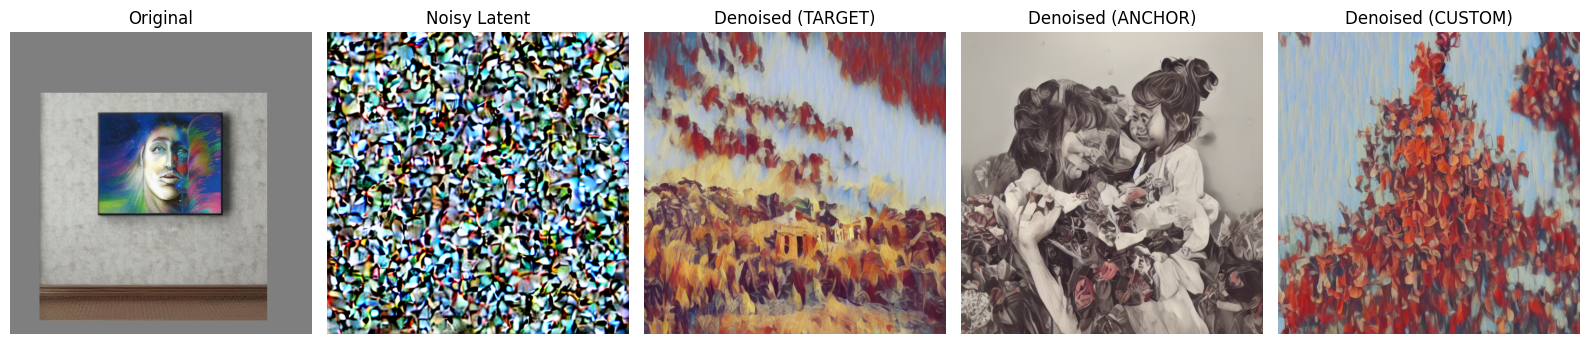

In [71]:
def show_triplet(idx=0):
    fig = plt.figure(figsize=(16,6))  # wider since 4 images

    # Original (dataset image)
    orig = (pixel_values[idx] * 0.5 + 0.5).clamp(0,1).detach().float().cpu().permute(1,2,0).numpy()
    plt.subplot(1,5,1); plt.imshow(orig); plt.title("Original"); plt.axis("off")

    # Noisy Latent (decoded)
    nimg = imgs_noisy_latent[idx].detach().float().cpu().permute(1,2,0).numpy()
    plt.subplot(1,5,2); plt.imshow(nimg); plt.title("Noisy Latent"); plt.axis("off")

    # One-step denoise (TARGET)
    timg = imgs_target[idx].detach().float().cpu().permute(1,2,0).numpy()
    plt.subplot(1,5,3); plt.imshow(timg); plt.title("Denoised (TARGET)"); plt.axis("off")

    # One-step denoise (ANCHOR)
    aimg = imgs_anchor[idx].detach().float().cpu().permute(1,2,0).numpy()
    plt.subplot(1,5,4); plt.imshow(aimg); plt.title("Denoised (ANCHOR)"); plt.axis("off")

    cimg = imgs_custom[idx].detach().float().cpu().permute(1,2,0).numpy()
    plt.subplot(1,5,5); plt.imshow(cimg); plt.title("Denoised (CUSTOM)"); plt.axis("off")

    plt.tight_layout()
    plt.show()

# Display first item in batch
show_triplet(0)
